# LINK
1. https://www.youtube.com/watch?v=xvqsFTUsOmc
2. https://github.com/adashofdata/nlp-in-python-tutorial

# 1. Data Cleaning

## Getting The Data

In [41]:
# Web scraping, pickle imports
import requests
from bs4 import BeautifulSoup
import pickle

# Scrapes
def url_to_transcript(url):
    page = requests.get(url).text
    soup = BeautifulSoup(page, "lxml")
    text = [p.text for p in soup.find(class_=["article-body", "article-body-commercial-selector"]).find_all('p')]
    print(url)
    return text

# URLs of transcripts in scope
urls = ['https://www.washingtonpost.com/health/2021/06/07/fda-approves-alzheimers-drug-aducanumab/',
        'https://www.theguardian.com/society/2021/jun/07/fda-announce-decision-new-alzheimers-drug-aducanumab']

# Comedian names
papers = ['washingtonpost', 'theguardian']

In [42]:
transcripts = [url_to_transcript(u) for u in urls]

https://www.washingtonpost.com/health/2021/06/07/fda-approves-alzheimers-drug-aducanumab/
https://www.theguardian.com/society/2021/jun/07/fda-announce-decision-new-alzheimers-drug-aducanumab


In [43]:
# remove directory
%rm -rf transcripts

In [44]:
# # Pickle files for later use

# # Make a new directory to hold the text files
!mkdir transcripts

for i, c in enumerate(papers):
    with open("transcripts/" + c + ".txt", "wb") as file:
        pickle.dump(transcripts[i], file)

In [45]:
# Load pickled files
data = {}
for i, c in enumerate(papers):
    with open("transcripts/" + c + ".txt", "rb") as file:
        data[c] = pickle.load(file)

In [46]:
# Double check to make sure data has been loaded properly
data.keys()

dict_keys(['washingtonpost', 'theguardian'])

In [47]:
# More checks
data['washingtonpost'][:2]

['The Food and Drug Administration on Monday approved the first Alzheimer’s treatment intended to slow cognitive decline, a move hailed by patients and advocates but sharply criticized by others who argued there was not sufficient evidence that the drug works.',
 'The medication, called aducanumab, is the first drug cleared for Alzheimer’s that is designed to alter the course of the disease by slowing the deterioration of brain function — not just to ease symptoms. No Alzheimer’s treatment has been approved since 2003, reflecting the extraordinarily high failure rate of drugs developed for the illness.']

## Cleaning The Data

In [48]:
# Let's take a look at our data again
next(iter(data.keys()))

'washingtonpost'

In [49]:
# Notice that our dictionary is currently in key: comedian, value: list of text format
next(iter(data.values()))

['The Food and Drug Administration on Monday approved the first Alzheimer’s treatment intended to slow cognitive decline, a move hailed by patients and advocates but sharply criticized by others who argued there was not sufficient evidence that the drug works.',
 'The medication, called aducanumab, is the first drug cleared for Alzheimer’s that is designed to alter the course of the disease by slowing the deterioration of brain function — not just to ease symptoms. No Alzheimer’s treatment has been approved since 2003, reflecting the extraordinarily high failure rate of drugs developed for the illness.',
 'But in an explicit acknowledgment of the uncertainties about the effectiveness of the drug, the FDA did not grant the medication full approval. Instead, the agency cleared the drug — its brand name will be Aduhelm — based on its ability to reduce clumps of amyloid beta in the brain, a hallmark of the disease. It ordered the drug’s maker, the biotech giant Biogen, to conduct a post-ap

In [50]:
# We are going to change this to key: comedian, value: string format
def combine_text(list_of_text):
    '''Takes a list of text and combines them into one large chunk of text.'''
    combined_text = ' '.join(list_of_text)
    return combined_text

In [51]:
# Combine it!
data_combined = {key: [combine_text(value)] for (key, value) in data.items()}

In [52]:
# We can either keep it in dictionary format or put it into a pandas dataframe
import pandas as pd
pd.set_option('max_colwidth',150)

data_df = pd.DataFrame.from_dict(data_combined).transpose()
data_df.columns = ['transcript']
data_df = data_df.sort_index()
data_df

,transcript
theguardian,"A controversial new drug for Alzheimer’s disease, the first in nearly 20 years, was approved in the US on Monday, which will trigger pressure to m..."
washingtonpost,"The Food and Drug Administration on Monday approved the first Alzheimer’s treatment intended to slow cognitive decline, a move hailed by patients ..."


In [53]:
# Let's take a look at the transcript for Ali Wong
data_df.transcript.loc['washingtonpost']

"The Food and Drug Administration on Monday approved the first Alzheimer’s treatment intended to slow cognitive decline, a move hailed by patients and advocates but sharply criticized by others who argued there was not sufficient evidence that the drug works. The medication, called aducanumab, is the first drug cleared for Alzheimer’s that is designed to alter the course of the disease by slowing the deterioration of brain function — not just to ease symptoms. No Alzheimer’s treatment has been approved since 2003, reflecting the extraordinarily high failure rate of drugs developed for the illness. But in an explicit acknowledgment of the uncertainties about the effectiveness of the drug, the FDA did not grant the medication full approval. Instead, the agency cleared the drug — its brand name will be Aduhelm — based on its ability to reduce clumps of amyloid beta in the brain, a hallmark of the disease. It ordered the drug’s maker, the biotech giant Biogen, to conduct a post-approval st

In [54]:
# Apply a first round of text cleaning techniques
import re
import string

def clean_text_round1(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

round1 = lambda x: clean_text_round1(x)

In [55]:
# Let's take a look at the updated text
data_clean = pd.DataFrame(data_df.transcript.apply(round1))
data_clean

,transcript
theguardian,a controversial new drug for alzheimer’s disease the first in nearly years was approved in the us on monday which will trigger pressure to make i...
washingtonpost,the food and drug administration on monday approved the first alzheimer’s treatment intended to slow cognitive decline a move hailed by patients a...


In [56]:
# Apply a second round of cleaning
def clean_text_round2(text):
    '''Get rid of some additional punctuation and non-sensical text that was missed the first time around.'''
    text = re.sub('[‘’“”…]', '', text)
    text = re.sub('\n', '', text)
    return text

round2 = lambda x: clean_text_round2(x)

In [57]:
# Let's take a look at the updated text
data_clean = pd.DataFrame(data_clean.transcript.apply(round2))
data_clean

,transcript
theguardian,a controversial new drug for alzheimers disease the first in nearly years was approved in the us on monday which will trigger pressure to make it...
washingtonpost,the food and drug administration on monday approved the first alzheimers treatment intended to slow cognitive decline a move hailed by patients an...


## Organizing The Data

### Corpus

In [58]:
# Let's take a look at our dataframe
data_df

,transcript
theguardian,"A controversial new drug for Alzheimer’s disease, the first in nearly 20 years, was approved in the US on Monday, which will trigger pressure to m..."
washingtonpost,"The Food and Drug Administration on Monday approved the first Alzheimer’s treatment intended to slow cognitive decline, a move hailed by patients ..."


In [59]:
# Let's add the comedians' full names as well
full_names = ['The Guardian', 'Washington Post']

data_df['full_name'] = full_names
data_df

,transcript,full_name
theguardian,"A controversial new drug for Alzheimer’s disease, the first in nearly 20 years, was approved in the US on Monday, which will trigger pressure to m...",The Guardian
washingtonpost,"The Food and Drug Administration on Monday approved the first Alzheimer’s treatment intended to slow cognitive decline, a move hailed by patients ...",Washington Post


In [60]:
# Let's pickle it for later use
data_df.to_pickle("corpus.pkl")

### Document-Term Matrix

In [61]:
# We are going to create a document-term matrix using CountVectorizer, and exclude common English stop words
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(stop_words='english')
data_cv = cv.fit_transform(data_clean.transcript)
data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
data_dtm.index = data_clean.index
data_dtm

,ability,able,absence,accelerated,access,according,acknowledgment,acrimonious,activities,actually,adding,additional,administer,administration,aducanumab,aduhelm,advisers,advisory,advocacy,advocates,age,agency,agencys,ago,alexander,alter,alzheimers,amazed,amazingly,americans,amyloid,amyloidreducing,analysis,announced,announcement,antialzheimers,antiamyloid,antibody,appear,appeared,...,unhappy,united,university,unlikely,unmet,use,used,usefulness,using,usually,valuable,value,victory,view,viewed,vounatsos,want,watch,watchdog,watershed,way,weak,went,wide,widely,wife,withdrawn,work,worked,working,works,world,worldwide,worth,writing,wrote,yank,year,years,york
theguardian,1,0,1,0,1,0,0,0,1,0,0,0,0,1,3,0,2,0,0,0,1,0,0,1,1,0,6,1,1,0,2,0,0,1,0,0,0,1,1,1,...,1,0,0,1,0,3,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,1,0,0,2,1,0,0,1,1,1,1,0,0,0,2,1
washingtonpost,1,1,0,1,0,1,1,1,0,1,1,1,1,1,5,3,0,2,2,2,1,4,3,1,2,1,16,0,0,1,10,1,2,0,1,1,1,1,0,0,...,0,1,1,0,2,0,1,0,1,1,1,1,1,1,1,1,0,1,1,1,2,1,0,0,1,1,1,1,0,1,3,0,0,0,0,1,1,3,6,0


In [62]:
# Let's pickle it for later use
data_dtm.to_pickle("dtm.pkl")

In [63]:
# Let's also pickle the cleaned data (before we put it in document-term matrix format) and the CountVectorizer object
data_clean.to_pickle('data_clean.pkl')
pickle.dump(cv, open("cv.pkl", "wb"))

# Exploratory Data Analysis

## Most Common Words

In [64]:
# Read in the document-term matrix
import pandas as pd

data = pd.read_pickle('dtm.pkl')
data = data.transpose()
data.head()

,theguardian,washingtonpost
ability,1,1
able,0,1
absence,1,0
accelerated,0,1
access,1,0


In [65]:
# Find the top 30 words said by each comedian
top_dict = {}
for c in data.columns:
    top = data[c].sort_values(ascending=False).head(30)
    top_dict[c]= list(zip(top.index, top.values))

top_dict

{'theguardian': [('drug', 13),
  ('drugs', 6),
  ('alzheimers', 6),
  ('approved', 5),
  ('disease', 5),
  ('people', 4),
  ('patients', 4),
  ('new', 4),
  ('fda', 4),
  ('memory', 4),
  ('data', 4),
  ('decline', 3),
  ('dementia', 3),
  ('means', 3),
  ('treatments', 3),
  ('use', 3),
  ('nhs', 3),
  ('brain', 3),
  ('trial', 3),
  ('said', 3),
  ('does', 3),
  ('mental', 3),
  ('plaques', 3),
  ('slow', 3),
  ('probably', 3),
  ('aducanumab', 3),
  ('intervention', 2),
  ('trials', 2),
  ('health', 2),
  ('forward', 2)],
 'washingtonpost': [('drug', 23),
  ('said', 23),
  ('patients', 18),
  ('alzheimers', 16),
  ('fda', 14),
  ('approval', 11),
  ('drugs', 10),
  ('amyloid', 10),
  ('disease', 9),
  ('decision', 8),
  ('treatment', 8),
  ('biogen', 8),
  ('people', 7),
  ('monday', 7),
  ('medication', 7),
  ('cognitive', 6),
  ('clinical', 6),
  ('data', 6),
  ('company', 6),
  ('years', 6),
  ('clumps', 6),
  ('study', 6),
  ('fdas', 6),
  ('trials', 5),
  ('aducanumab', 5),
  (

In [66]:
# Print the top 15 words said by each comedian
for paper, top_words in top_dict.items():
    print(paper)
    print(', '.join([word for word, count in top_words[0:14]]))
    print('---')

theguardian
drug, drugs, alzheimers, approved, disease, people, patients, new, fda, memory, data, decline, dementia, means
---
washingtonpost
drug, said, patients, alzheimers, fda, approval, drugs, amyloid, disease, decision, treatment, biogen, people, monday
---


In [67]:
# Look at the most common top words --> add them to the stop word list
from collections import Counter

# Let's first pull out the top 30 words for each comedian
words = []
for paper in data.columns:
    top = [word for (word, count) in top_dict[paper]]
    for t in top:
        words.append(t)
        
words

['drug',
 'drugs',
 'alzheimers',
 'approved',
 'disease',
 'people',
 'patients',
 'new',
 'fda',
 'memory',
 'data',
 'decline',
 'dementia',
 'means',
 'treatments',
 'use',
 'nhs',
 'brain',
 'trial',
 'said',
 'does',
 'mental',
 'plaques',
 'slow',
 'probably',
 'aducanumab',
 'intervention',
 'trials',
 'health',
 'forward',
 'drug',
 'said',
 'patients',
 'alzheimers',
 'fda',
 'approval',
 'drugs',
 'amyloid',
 'disease',
 'decision',
 'treatment',
 'biogen',
 'people',
 'monday',
 'medication',
 'cognitive',
 'clinical',
 'data',
 'company',
 'years',
 'clumps',
 'study',
 'fdas',
 'trials',
 'aducanumab',
 'called',
 'brain',
 'time',
 'studies',
 'agency']

In [68]:
# Let's aggregate this list and identify the most common words along with how many routines they occur in
Counter(words).most_common()

[('drug', 2),
 ('drugs', 2),
 ('alzheimers', 2),
 ('disease', 2),
 ('people', 2),
 ('patients', 2),
 ('fda', 2),
 ('data', 2),
 ('brain', 2),
 ('said', 2),
 ('aducanumab', 2),
 ('trials', 2),
 ('approved', 1),
 ('new', 1),
 ('memory', 1),
 ('decline', 1),
 ('dementia', 1),
 ('means', 1),
 ('treatments', 1),
 ('use', 1),
 ('nhs', 1),
 ('trial', 1),
 ('does', 1),
 ('mental', 1),
 ('plaques', 1),
 ('slow', 1),
 ('probably', 1),
 ('intervention', 1),
 ('health', 1),
 ('forward', 1),
 ('approval', 1),
 ('amyloid', 1),
 ('decision', 1),
 ('treatment', 1),
 ('biogen', 1),
 ('monday', 1),
 ('medication', 1),
 ('cognitive', 1),
 ('clinical', 1),
 ('company', 1),
 ('years', 1),
 ('clumps', 1),
 ('study', 1),
 ('fdas', 1),
 ('called', 1),
 ('time', 1),
 ('studies', 1),
 ('agency', 1)]

In [69]:
# If more than half of the comedians have it as a top word, exclude it from the list
add_stop_words = [word for word, count in Counter(words).most_common() if count > 1]
add_stop_words

['drug',
 'drugs',
 'alzheimers',
 'disease',
 'people',
 'patients',
 'fda',
 'data',
 'brain',
 'said',
 'aducanumab',
 'trials']

In [70]:
# Let's update our document-term matrix with the new list of stop words
from sklearn.feature_extraction import text 
from sklearn.feature_extraction.text import CountVectorizer

# Read in cleaned data
data_clean = pd.read_pickle('data_clean.pkl')

# Add new stop words
stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words)

# Recreate document-term matrix
cv = CountVectorizer(stop_words=stop_words)
data_cv = cv.fit_transform(data_clean.transcript)
data_stop = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
data_stop.index = data_clean.index

# Pickle it for later use
import pickle
pickle.dump(cv, open("cv_stop.pkl", "wb"))
data_stop.to_pickle("dtm_stop.pkl")

In [71]:

# Let's make some word clouds!
# Terminal / Anaconda Prompt: conda install -c conda-forge wordcloud
from wordcloud import WordCloud

wc = WordCloud(stopwords=stop_words, background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)

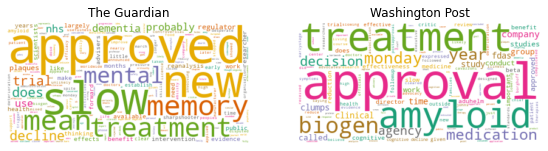

In [72]:
# Reset the output dimensions
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [20, 8]

full_names = ['The Guardian', 'Washington Post']

# Create subplots for each comedian
for index, comedian in enumerate(data.columns):
    wc.generate(data_clean.transcript[comedian])
    
    plt.subplot(3, 4, index+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(full_names[index])
    
plt.show()

## Number of Words (Vocabulary)

In [73]:

# Find the number of unique words that each comedian uses

# Identify the non-zero items in the document-term matrix, meaning that the word occurs at least once
unique_list = []
for comedian in data.columns:
    uniques = data[comedian].to_numpy().nonzero()[0].size
    unique_list.append(uniques)

# Create a new dataframe that contains this unique word count
data_words = pd.DataFrame(list(zip(full_names, unique_list)), columns=['paper', 'unique_words'])
data_unique_sort = data_words.sort_values(by='unique_words')
data_unique_sort

,paper,unique_words
0,The Guardian,270
1,Washington Post,544


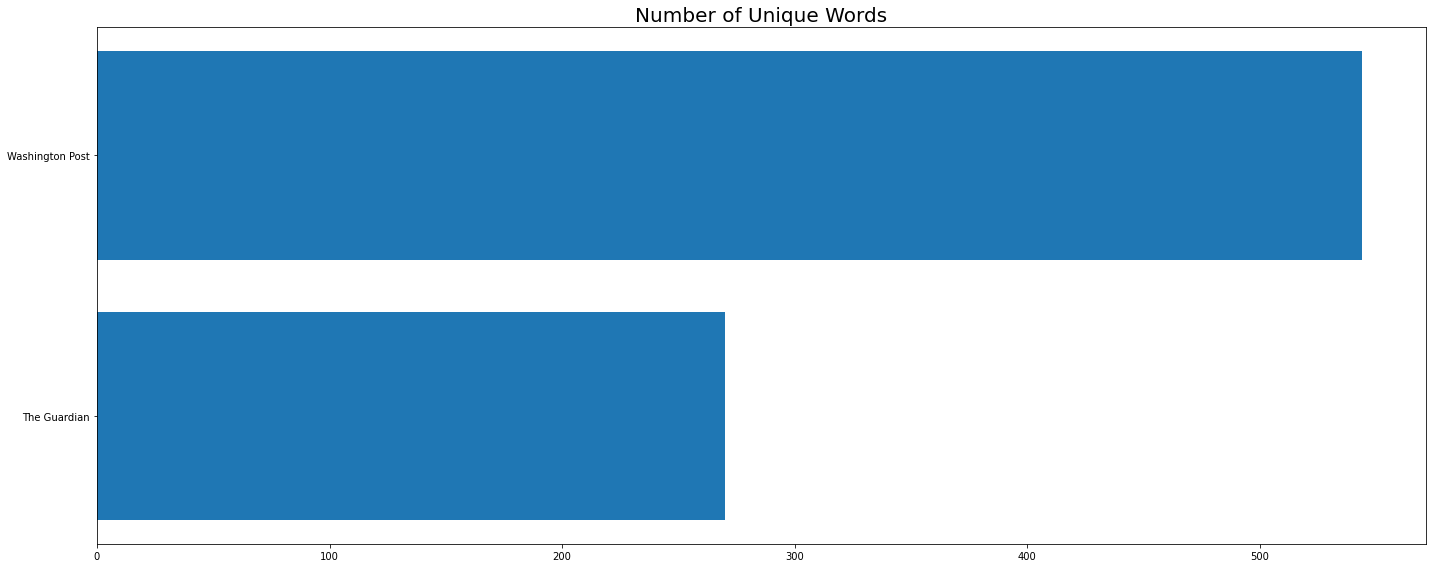

In [75]:

# Let's plot our findings
import numpy as np

y_pos = np.arange(len(data_words))

plt.subplot(1, 1, 1)
plt.barh(y_pos, data_unique_sort.unique_words, align='center')
plt.yticks(y_pos, data_unique_sort.paper)
plt.title('Number of Unique Words', fontsize=20)


plt.tight_layout()
plt.show()

## Bad words

In [76]:
# Earlier I said we'd revisit profanity. Let's take a look at the most common words again.
Counter(words).most_common()

[('drug', 2),
 ('drugs', 2),
 ('alzheimers', 2),
 ('disease', 2),
 ('people', 2),
 ('patients', 2),
 ('fda', 2),
 ('data', 2),
 ('brain', 2),
 ('said', 2),
 ('aducanumab', 2),
 ('trials', 2),
 ('approved', 1),
 ('new', 1),
 ('memory', 1),
 ('decline', 1),
 ('dementia', 1),
 ('means', 1),
 ('treatments', 1),
 ('use', 1),
 ('nhs', 1),
 ('trial', 1),
 ('does', 1),
 ('mental', 1),
 ('plaques', 1),
 ('slow', 1),
 ('probably', 1),
 ('intervention', 1),
 ('health', 1),
 ('forward', 1),
 ('approval', 1),
 ('amyloid', 1),
 ('decision', 1),
 ('treatment', 1),
 ('biogen', 1),
 ('monday', 1),
 ('medication', 1),
 ('cognitive', 1),
 ('clinical', 1),
 ('company', 1),
 ('years', 1),
 ('clumps', 1),
 ('study', 1),
 ('fdas', 1),
 ('called', 1),
 ('time', 1),
 ('studies', 1),
 ('agency', 1)]

In [78]:

# Let's isolate just these bad words
data_bad_words = data.transpose()[['fucking', 'fuck', 'shit']]
data_profanity = pd.concat([data_bad_words.fucking + data_bad_words.fuck, data_bad_words.shit], axis=1)
data_profanity.columns = ['f_word', 's_word']
data_profanity

KeyError: ignored

In [77]:
# Let's create a scatter plot of our findings
plt.rcParams['figure.figsize'] = [10, 8]

for i, paper in enumerate(data_profanity.index):
    x = data_profanity.f_word.loc[paper]
    y = data_profanity.s_word.loc[paper]
    plt.scatter(x, y, color='blue')
    plt.text(x+1.5, y+0.5, full_names[i], fontsize=10)
    plt.xlim(-5, 155) 
    
plt.title('Number of Bad Words Used in Routine', fontsize=20)
plt.xlabel('Number of F Bombs', fontsize=15)
plt.ylabel('Number of S Words', fontsize=15)

plt.show()

NameError: ignored